<a href="https://colab.research.google.com/github/rakeshpa85/NLP/blob/main/NLP_MiniProject_RakeshPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

import nltk

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize 
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
raw_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Mini_Project/NLP/NLPMiniProject_data.csv')
raw_df.head(5)

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


### Remove undisclosed / Classified columns

In [4]:
raw_df.drop(labels=['down','score','top'],axis=1,inplace=True)
raw_df.head(5)

,ID,comment,date,parent_comment,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,They should shut the fuck up and let the commu...,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,You need evidence to kill people? I thought we...,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,2014 BMW S1000R: Official Promo,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,Not really that memorable lol if you want memo...,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,James Neal hit on Zach Parise,hockey,Somuch101,1


### EDA

In [5]:
print("Total observations :", raw_df.shape[0])
print("Distinct UIDs :", raw_df['ID'].nunique())
print("Distinct Topics :", raw_df['topic'].nunique())
print("Distinct users :", raw_df['user'].nunique())
print("Distinct labels :", raw_df['label'].nunique())
print("Min date :", pd.to_datetime(raw_df['date']).min())
print("Max date :", pd.to_datetime(raw_df['date']).max())

Total observations : 15000
Distinct UIDs : 15000
Distinct Topics : 2272
Distinct users : 13987
Distinct labels : 2
Min date : 2009-01-01 00:00:00
Max date : 2016-12-01 00:00:00


In [6]:
raw_df.describe()

,label
count,15000.000000
mean,0.501800
std,0.500013
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


### Check if data is balanced w.r.t target 

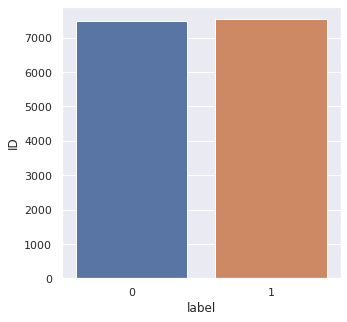

In [7]:
label_agg_df = pd.DataFrame(raw_df.groupby(by=['label'])['ID'].count()).reset_index()
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(x='label',y='ID',data= label_agg_df)

**Inference :** Data is balanced

### Overall Count Distribution of Topic

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


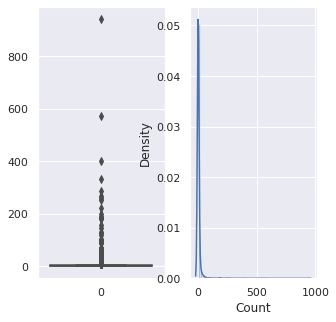

In [8]:
lbltopic_agg_df = pd.DataFrame(raw_df.groupby(by=['topic'])['ID'].count()).reset_index().rename(columns={'ID':'Count'})
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(25,15)})
sns.boxplot(data=lbltopic_agg_df['Count'], ax=axs[0])
sns.distplot(lbltopic_agg_df['Count'], ax=axs[1])

### Target Class-wise Count Distribution of Topic : Using Box-Plot

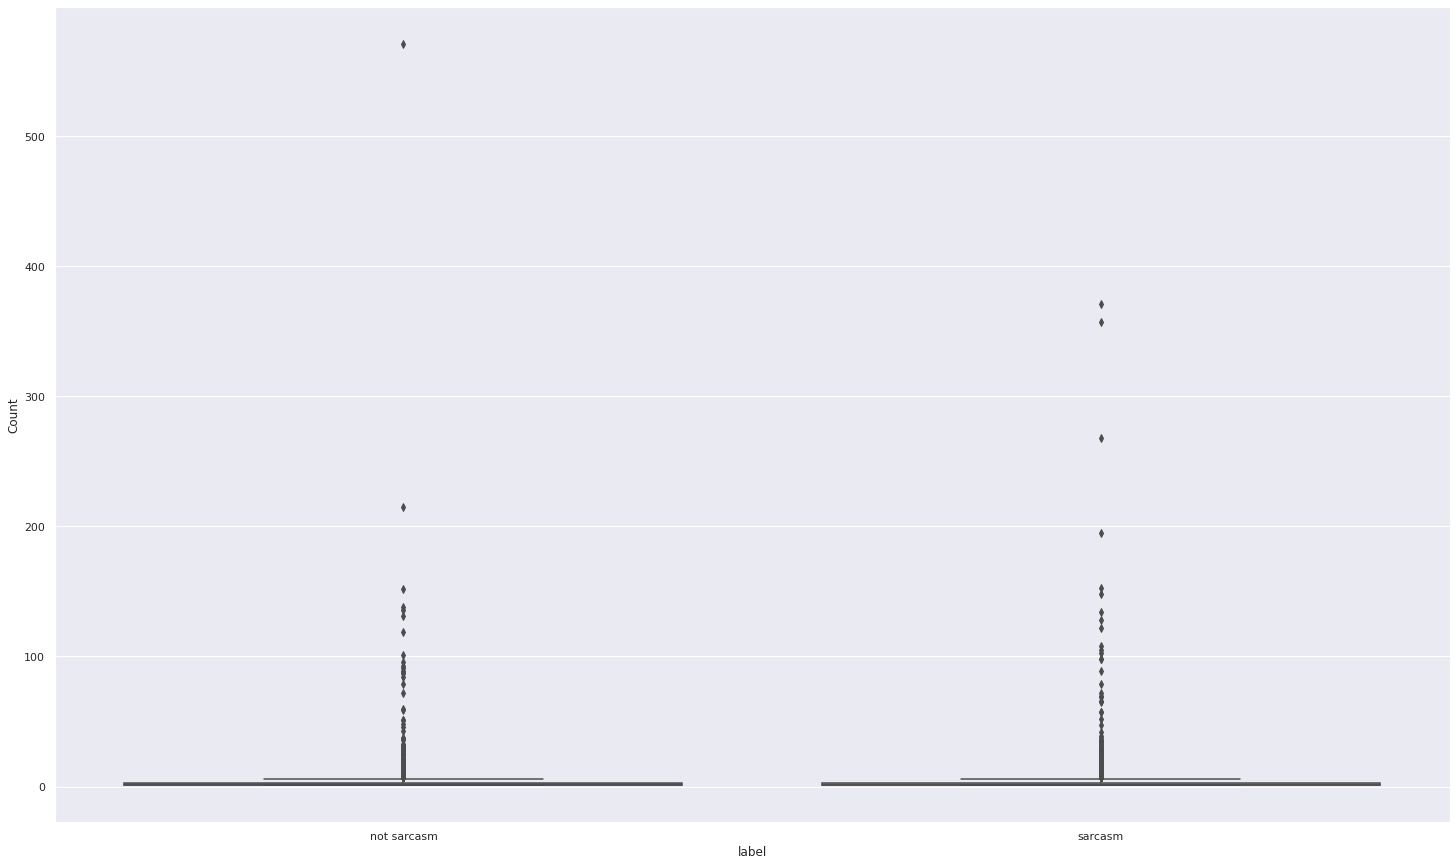

In [9]:
lbltopic_agg_df = pd.DataFrame(raw_df.groupby(by=['label','topic'])['ID'].count()).reset_index().rename(columns={'ID':'Count'})
lbltopic_agg_df['label'] = lbltopic_agg_df['label'].map({1: 'sarcasm', 0: 'not sarcasm'})
sns.set(rc={'figure.figsize':(25,15)})
sns.boxplot(x='label',y='Count',data=lbltopic_agg_df)

### Target Class-wise Count Distribution of Topic : Using Distplot

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


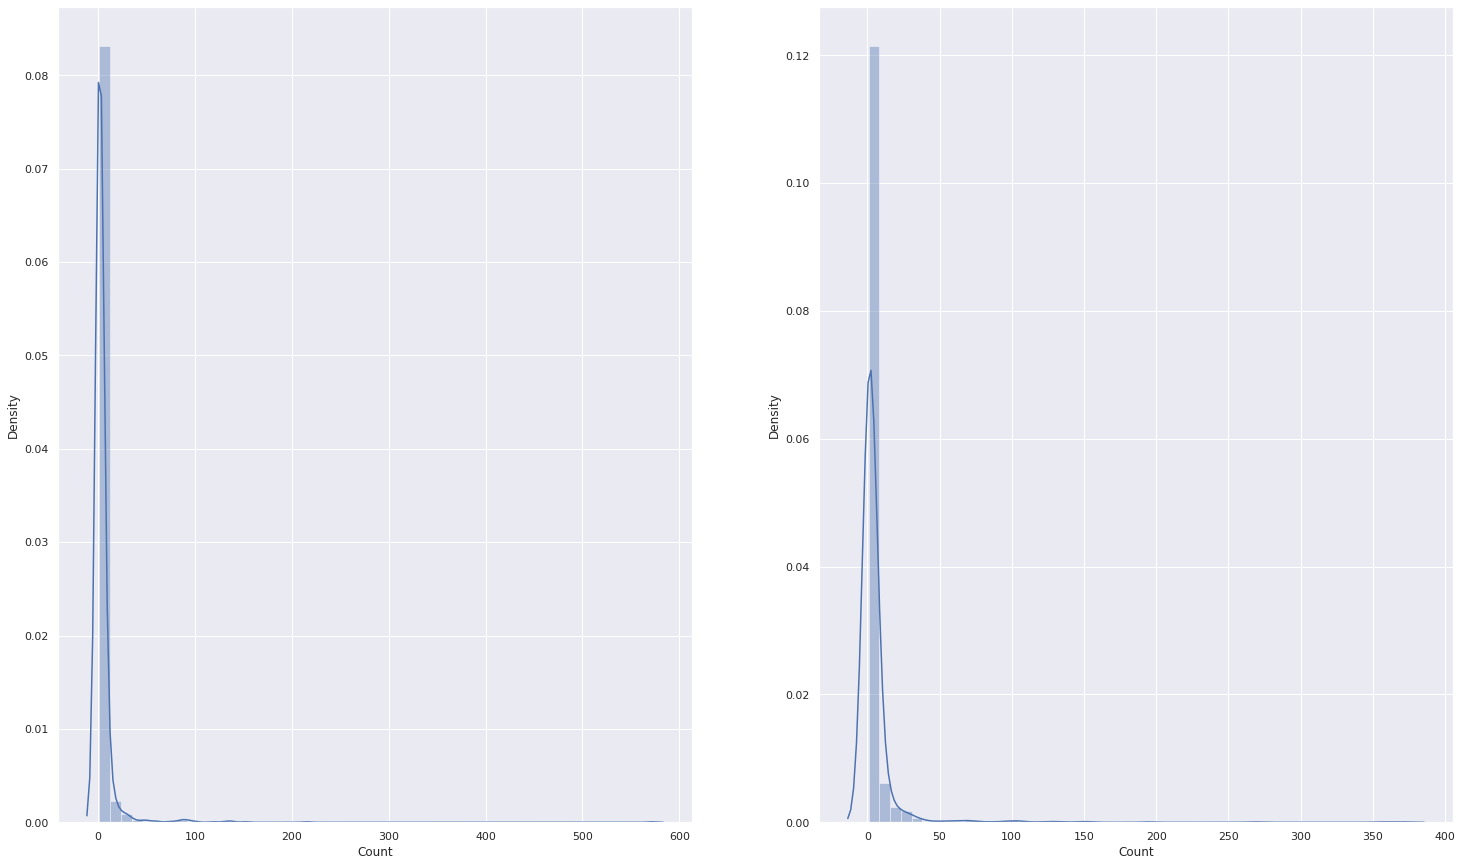

In [10]:
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(25,10)})
sns.distplot(lbltopic_agg_df.loc[lbltopic_agg_df['label'] == 'not sarcasm']['Count'], ax=axs[0])
sns.distplot(lbltopic_agg_df.loc[lbltopic_agg_df['label'] == 'sarcasm']['Count'], ax=axs[1])

**Inference:** Both target classes are imbalanced to comparable extent w.r.t topics

### Dataset Cleaning

In [11]:
raw_df

,ID,comment,date,parent_comment,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,They should shut the fuck up and let the commu...,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,You need evidence to kill people? I thought we...,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,2014 BMW S1000R: Official Promo,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,Not really that memorable lol if you want memo...,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,James Neal hit on Zach Parise,hockey,Somuch101,1
...,...,...,...,...,...,...,...
14995,uid_845344,Well with a name like El Cubano I'm surprised ...,2015-01,There's two things you don't do in Florida. - ...,hockey,shutupisaac,0
14996,uid_757880,... This is a good point.,2014-04,Sounds like a pretty good overall summary of o...,hockey,em483,0
14997,uid_724706,Yep.,2015-09,"I know the type you speak of. The ""die cis scu...",AskReddit,YoImAli,0
14998,uid_1006984,That's what the government WANTS you to believe!,2016-01,That there's A hidden cure for cancer but phar...,AskReddit,OhHiGCHQ,1


In [12]:
## Tokenize, Lowercase, Remove Punctuations, Remove Stopwords

def clean_txt(p_srs):

  ## Tokenize the text data
  document_text = p_srs
  datalist = []
  for data_ele in document_text:datalist.append(RegexpTokenizer('\w+').tokenize(data_ele))

  ## Lowercase

  lowercase_txt = []
  for line_ele in datalist:lowercase_txt.append(list(map(lambda x : x.lower(),line_ele)))

  ## Remove Punctuations

  punctlist = [";",":","!","?","/","\\",",","#","@","$","&",")","(","\""]
  punc_filtr = []

  for line_ele in lowercase_txt:
      punc_char=[]
      for wrd in line_ele:
          if wrd not in punctlist:
              punc_char.append(wrd)
      punc_filtr.append(punc_char)

  ## Remove Stopwords

  stop_words = set(stopwords.words('english'))
  nonsw_sent = []

  for data_ele in punc_filtr:
      nonsw_wrd = []
      for wrd in data_ele:
          if wrd not in stop_words:
              nonsw_wrd.append(wrd)
      nonsw_sent.append(nonsw_wrd)

  return nonsw_sent

In [13]:
def get_lemm(p_list):
  ### Lemmatizing the Stemmed data
  lanc_stm = LancasterStemmer()

  lemm = []
  for data_ele in p_list:
      lemm.append(list(map(lambda x : lanc_stm.stem(x),data_ele)))

  return lemm

In [14]:
def get_stemm(p_list):
  ### Stemming the text data and stopword removal
  porter = PorterStemmer()
  stemmed = []

  for data_ele in p_list:
      stemmed.append(list(map(lambda x: porter.stem(x),data_ele)))
      
  return stemmed

In [15]:
def tonkn_to_sent(p_list):
  cln_X = p_list

  cln_sent = []

  for data_ele in cln_X:
      seq = ''
      for wrd in data_ele:
          seq = seq + ' ' + wrd
      cln_sent.append(seq)

  cln_X = cln_sent
  return cln_X

In [16]:
def clean_lemm_stemm_sent(p_srs,p_std_apprch='lemm'):
  clean_txt_list = clean_txt(p_srs)

  if p_std_apprch == 'stemm':
    stdapprch_list = get_stemm(clean_txt_list)
  else:
    stdapprch_list = get_lemm(clean_txt_list)

  cln_sent_list = tonkn_to_sent(stdapprch_list)

  return cln_sent_list

In [17]:
raw_df

,ID,comment,date,parent_comment,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,They should shut the fuck up and let the commu...,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,You need evidence to kill people? I thought we...,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,2014 BMW S1000R: Official Promo,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,Not really that memorable lol if you want memo...,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,James Neal hit on Zach Parise,hockey,Somuch101,1
...,...,...,...,...,...,...,...
14995,uid_845344,Well with a name like El Cubano I'm surprised ...,2015-01,There's two things you don't do in Florida. - ...,hockey,shutupisaac,0
14996,uid_757880,... This is a good point.,2014-04,Sounds like a pretty good overall summary of o...,hockey,em483,0
14997,uid_724706,Yep.,2015-09,"I know the type you speak of. The ""die cis scu...",AskReddit,YoImAli,0
14998,uid_1006984,That's what the government WANTS you to believe!,2016-01,That there's A hidden cure for cancer but phar...,AskReddit,OhHiGCHQ,1


In [18]:
cln_lemm_df = pd.DataFrame()
cln_lemm_df['comment_cln'] = clean_lemm_stemm_sent(raw_df['comment'],'lemm')
cln_lemm_df['parent_comment_cln'] = clean_lemm_stemm_sent(raw_df['parent_comment'],'lemm')
cln_lemm_df['topic'] = list(raw_df['topic'])
cln_lemm_df['label'] = list(raw_df['label'])
cln_lemm_df.head(5)

,comment_cln,parent_comment_cln,topic,label
0,wel let honest act seem much mod spend tim so...,shut fuck let commun decid want subreddit mod...,starcitizen,0
1,wel nee evid believ commun,nee evid kil peopl thought sum execut suspect...,EnoughCommieSpam,1
2,off promo 360p,2014 bmw s1000r off promo,motorcycles,0
3,grotto koth best,real mem lol want mem try badl templ ston heng,hcfactions,1
4,neal back baby,jam neal hit zach par,hockey,1


In [19]:
cln_stemm_df = pd.DataFrame()
cln_stemm_df['comment_cln'] = clean_lemm_stemm_sent(raw_df['comment'],'stemm')
cln_stemm_df['parent_comment_cln'] = clean_lemm_stemm_sent(raw_df['parent_comment'],'stemm')
cln_stemm_df['topic'] = list(raw_df['topic'])
cln_stemm_df['label'] = list(raw_df['label'])
cln_stemm_df.head(5)

,comment_cln,parent_comment_cln,topic,label
0,well let honest actual seem much moder spend ...,shut fuck let commun decid want subreddit mod...,starcitizen,0
1,well need evid believ commun,need evid kill peopl thought summarili execut...,EnoughCommieSpam,1
2,offici promo 360p,2014 bmw s1000r offici promo,motorcycles,0
3,grotto koth best,realli memor lol want memor tri badlion templ...,hcfactions,1
4,neal back babi,jame neal hit zach paris,hockey,1


In [20]:
clean_txt_list = clean_txt(raw_df['comment'])
stdapprch_list = get_lemm(clean_txt_list)
# stdapprch_list

In [21]:
## Create Vocabulary
voc_list = []
for data_ele in stdapprch_list:
    voc_list.extend(data_ele)
print(voc_list[:20])
print(len(voc_list))

['wel', 'let', 'honest', 'act', 'seem', 'much', 'mod', 'spend', 'tim', 'someth', 'wel', 'nee', 'evid', 'believ', 'commun', 'off', 'promo', '360p', 'grotto', 'koth']
83663


In [22]:
CountVectorizer

sklearn.feature_extraction.text.CountVectorizer

Function for CountVectorizing and getting Top N keywords

In [23]:
def get_topCVterms(p_df,p_topn=5):
  vec = CountVectorizer(min_df=2,max_df=0.95)
  res = vec.fit_transform(p_df)
  print(res.shape)

  feature_array = np.array(vec.get_feature_names())
  CV_sorting = np.argsort(res.toarray()).flatten()[::-1]

  top_n = feature_array[CV_sorting][:p_topn]
  return top_n

CountVectorize and show top 50 significant keywords in Lemmatized overall Comments

In [24]:
get_topCVterms(cln_lemm_df['comment_cln'],50)

(15000, 5104)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['menu', 'glory', 'window', 'perfect', 'start', '10', 'favorit',
       'fash', 'fb', 'fart', 'farth', 'fasc', 'fascin', 'favourit',
       'fast', 'fav', 'fastest', 'fat', 'farm', 'fatty', 'fault', 'faux',
       'fath', 'zum', 'fargo', 'famili', 'fairy', 'fak', 'fal', 'falcon',
       'fallout', 'fals', 'fam', 'famy', 'far', 'fan', 'fanbas', 'fanboy',
       'fant', 'fantast', 'fantasy', 'fap', 'fbi', 'feat', 'fda', 'film',
       'fi', 'fict', 'field', 'fif'], dtype='<U15')

CountVectorize and show top 50 significant keywords in Lemmatized Non-Sarcasm Comments

In [25]:
get_topCVterms(cln_lemm_df.loc[cln_lemm_df['label'] == 0]['comment_cln'],50)

(7473, 3423)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['yep', 'zon', 'fai', 'famy', 'famili', 'fam', 'fallout', 'falcon',
       'fal', 'fak', 'fairy', 'fair', 'fail', 'faggot', 'fanboy', 'fact',
       'facil', 'facebook', 'fac', 'f5', 'ez', 'ey', 'extrem', 'extract',
       'extr', 'extinct', 'fan', 'fant', 'ext', 'fantast', 'feet', 'feel',
       'feedback', 'fee', 'fed', 'febru', 'feat', 'fear', 'fb',
       'favourit', 'favorit', 'fav', 'faux', 'fault', 'fatty', 'fath',
       'fat', 'fastest', 'fast', 'fasc'], dtype='<U15')

CountVectorize and show top 50 significant keywords in Lemmatized Sarcasm Comments

In [26]:
get_topCVterms(cln_lemm_df.loc[cln_lemm_df['label'] == 1]['comment_cln'],50)

(7527, 3302)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['perfect', 'glory', 'start', 'window', 'menu', '10', 'faggot',
       'fam', 'fals', 'fallout', 'falcon', 'fal', 'fak', 'fairy', 'fair',
       'fail', 'fai', 'fag', 'fan', 'fad', 'fact', 'facilit', 'facebook',
       'fac', 'ez', 'ey', 'extrem', 'extract', 'extr', 'famy', 'fanbas',
       'front', 'fath', 'fed', 'feat', 'fear', 'fda', 'fbi', 'favourit',
       'favorit', 'fav', 'fault', 'fatty', 'fat', 'fanboy', 'fastest',
       'fast', 'fash', 'fasc', 'fart'], dtype='<U13')

Function for TFIDF and getting Top N keywords

In [27]:
def get_toptfidfterms(p_df,p_topn=5):
  v = TfidfVectorizer(min_df=2,max_df=0.95)
  x = v.fit_transform(p_df)
  print(x.shape)

  feature_array = np.array(v.get_feature_names())
  tfidf_sorting = np.argsort(x.toarray()).flatten()[::-1]

  top_n = feature_array[tfidf_sorting][:p_topn]
  return top_n

TFIDF and show top 50 significant keywords in Lemmatizedoverall Comments

In [28]:
get_toptfidfterms(cln_lemm_df['comment_cln'],50)

(15000, 5104)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['menu', 'glory', 'window', 'perfect', '10', 'start', 'fav', 'fash',
       'fb', 'fart', 'farth', 'fasc', 'fascin', 'favourit', 'fast',
       'faux', 'fastest', 'fat', 'farm', 'fatty', 'fault', 'favorit',
       'fath', 'zum', 'fargo', 'famili', 'fairy', 'fak', 'fal', 'falcon',
       'fallout', 'fals', 'fam', 'famy', 'far', 'fan', 'fanbas', 'fanboy',
       'fant', 'fantast', 'fantasy', 'fap', 'fbi', 'feat', 'fda', 'film',
       'fi', 'fict', 'field', 'fif'], dtype='<U15')

TFIDF and show top 50 significant keywords in Lemmatized Non-Sarcasm Comments

In [29]:
get_toptfidfterms(cln_lemm_df.loc[cln_lemm_df['label'] == 0]['comment_cln'],50)

(7473, 3423)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['yep', 'zon', 'fai', 'famy', 'famili', 'fam', 'fallout', 'falcon',
       'fal', 'fak', 'fairy', 'fair', 'fail', 'faggot', 'fanboy', 'fact',
       'facil', 'facebook', 'fac', 'f5', 'ez', 'ey', 'extrem', 'extract',
       'extr', 'extinct', 'fan', 'fant', 'ext', 'fantast', 'feet', 'feel',
       'feedback', 'fee', 'fed', 'febru', 'feat', 'fear', 'fb',
       'favourit', 'favorit', 'fav', 'faux', 'fault', 'fatty', 'fath',
       'fat', 'fastest', 'fast', 'fasc'], dtype='<U15')

TFIDF and show top 50 significant keywords in Lemmatized Sarcasm Comments

In [30]:
get_toptfidfterms(cln_lemm_df.loc[cln_lemm_df['label'] == 1]['comment_cln'],50)

(7527, 3302)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['menu', 'glory', 'window', 'perfect', '10', 'start', 'fai', 'fam',
       'fals', 'fallout', 'falcon', 'fal', 'fak', 'fairy', 'fair', 'fail',
       'faggot', 'fan', 'fag', 'fad', 'fact', 'facilit', 'facebook',
       'fac', 'ez', 'ey', 'extrem', 'extract', 'famy', 'fanbas', 'extend',
       'fath', 'fed', 'feat', 'fear', 'fda', 'fbi', 'favourit', 'favorit',
       'fav', 'fault', 'fatty', 'fat', 'fanboy', 'fastest', 'fast',
       'fash', 'fasc', 'fart', 'farm'], dtype='<U13')

In [31]:
Train_X, Test_X, Train_y, Test_y = model_selection.train_test_split(cln_lemm_df['comment_cln'],cln_lemm_df['label'],random_state=123)

# Encoder = LabelEncoder()
# Train_y = Encoder.fit_transform(Train_y)
# Test_y = Encoder.fit_transform(Test_y)

tfidf_vect = TfidfVectorizer(max_features = 5000)
tfidf_vect.fit(cln_lemm_df['comment_cln'])
train_x_tfidf = tfidf_vect.transform(Train_X)
test_x_tfidf = tfidf_vect.transform(Test_X)

Logistic Regression Model on TFIDF Vectorized text data

In [32]:
lr_model = LogisticRegression(C=1.0)
lr_model.fit(train_x_tfidf, Train_y)
pred_lr = lr_model.predict(test_x_tfidf)
print("Accuracy Score :", accuracy_score(pred_lr,Test_y)*100)

Accuracy Score : 62.66666666666667


SVM Model on TFIDF Vectorized text data

In [33]:
SVM = SVC(C=1.0,kernel='linear',degree = 3, gamma = 'auto')
SVM.fit(train_x_tfidf, Train_y)
pred_svm = SVM.predict(test_x_tfidf)
print("Accuracy Score :", accuracy_score(pred_svm,Test_y)*100)

Accuracy Score : 61.519999999999996


In [34]:
Train_X.shape

(11250,)

In [35]:
train_x_tfidf.shape

(11250, 5000)

In [36]:
# # create tfidf2
# tfidf2 = tdf.transform(list_cluster)

# #create dates
# dates=['010000000000', '001000000000', '001000000000', '000000000001', '001000000000', '000000000010',...]

# # binarize dates
# lb = LabelBinarizer()
# b_dates = lb.fit_transform(dates)

# new_tfidf = np.concatenate((tfidf2, b_dates), axis=1)

In [37]:
cln_lemm_df = pd.concat([cln_lemm_df, pd.get_dummies(cln_lemm_df['topic'])],axis=1).drop(columns=['topic'])

In [38]:
Train_X, Test_X, Train_y, Test_y = model_selection.train_test_split(cln_lemm_df.drop(columns=['label']),cln_lemm_df['label'],random_state=123)

# Encoder = LabelEncoder()
# Train_y = Encoder.fit_transform(Train_y)
# Test_y = Encoder.fit_transform(Test_y)

tfidf_vect = TfidfVectorizer(max_features = 5000)
tfidf_vect.fit(cln_lemm_df['comment_cln'])
train_x_tfidf_stdcmnt = tfidf_vect.transform(Train_X['comment_cln'])
test_x_tfid_stdcmnt = tfidf_vect.transform(Test_X['comment_cln'])

tfidf_vect = TfidfVectorizer(max_features = 5000)
tfidf_vect.fit(cln_lemm_df['parent_comment_cln'])
train_x_tfidf_prntcmnt = tfidf_vect.transform(Train_X['parent_comment_cln'])
test_x_tfidf_prntcmnt = tfidf_vect.transform(Test_X['parent_comment_cln'])

In [39]:
train_x_tfidf_stdcmnt.shape, test_x_tfid_stdcmnt.shape, train_x_tfidf_prntcmnt.shape, test_x_tfidf_prntcmnt.shape

((11250, 5000), (3750, 5000), (11250, 5000), (3750, 5000))

In [40]:
cln_lemm_df.columns

Index(['comment_cln', 'parent_comment_cln', 'label', '100DaysofKeto',
       '100thieves', '112263Hulu', '2007scape', '2meirl4meirl', '30ROCK',
       '3DS',
       ...
       'xxfitness', 'yard', 'yesyesyesyesno', 'ynab', 'youdontsurf',
       'youtubehaiku', 'yoyhammer', 'yugioh', 'zelda', 'zen'],
      dtype='object', length=2275)

In [41]:
Train_X.shape

(11250, 2274)

In [42]:
pd.DataFrame(train_x_tfidf_stdcmnt.toarray()).shape

(11250, 5000)

In [43]:
Train_X.drop(columns=['comment_cln','parent_comment_cln']).shape

(11250, 2272)

In [44]:
# train_x_tfidf_stdcmnt_df = pd.DataFrame(train_x_tfidf_stdcmnt.toarray()).reset_index(drop=True)
# train_x_tfidf_prntcmnt_df = pd.DataFrame(train_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
# train_x_enccols = Train_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

# print(train_x_tfidf_stdcmnt_df.shape,train_x_tfidf_stdcmnt_df.shape, train_x_enccols.shape)

# train_x_full = pd.concat([train_x_tfidf_stdcmnt_df,train_x_tfidf_prntcmnt_df,train_x_enccols],axis=1,ignore_index=True)


# test_x_tfid_stdcmnt_df = pd.DataFrame(test_x_tfid_stdcmnt.toarray()).reset_index(drop=True)
# test_x_tfidf_prntcmnt_df = pd.DataFrame(test_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
# test_x_enccols = Test_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

# print(test_x_tfid_stdcmnt_df.shape,test_x_tfidf_prntcmnt_df.shape, test_x_enccols.shape)

# test_x_full = pd.concat([test_x_tfid_stdcmnt_df,test_x_tfidf_prntcmnt_df,test_x_enccols],axis=1,ignore_index=True)

# lr_model = LogisticRegression(C=1.0)
# lr_model.fit(train_x_full, Train_y)
# pred_lr = lr_model.predict(test_x_full)
# print("Accuracy Score LR:", accuracy_score(pred_lr,Test_y)*100)

# gnb_classifier = GaussianNB()
# gnb_classifier.fit(train_x_full, Train_y)
# gnb_pred  =  gnb_classifier.predict(test_x_full)
# print("Accuracy Score GaussianNB:", accuracy_score(gnb_pred,Test_y)*100)

# lda_model = LinearDiscriminantAnalysis(n_components=1)
# lda_model.fit(train_x_full, Train_y)
# lda_pred = lda_model.predict(test_x_full)
# print("Accuracy Score LDA:", accuracy_score(lda_pred,Test_y)*100)

# SVM = SVC(C=1.0,kernel='linear',degree = 3, gamma = 'auto')
# SVM.fit(train_x_full, Train_y)
# pred_svm = SVM.predict(test_x_full)
# print("Accuracy Score SVM:", accuracy_score(pred_svm,Test_y)*100)

In [45]:
# train_x_tfidf_stdcmnt_df = pd.DataFrame(train_x_tfidf_stdcmnt.toarray()).reset_index(drop=True)
# train_x_tfidf_prntcmnt_df = pd.DataFrame(train_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
# train_x_enccols = Train_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

# print(train_x_tfidf_stdcmnt_df.shape,train_x_tfidf_stdcmnt_df.shape, train_x_enccols.shape)

# train_x_full = pd.concat([train_x_tfidf_stdcmnt_df,train_x_enccols],axis=1,ignore_index=True)


# test_x_tfid_stdcmnt_df = pd.DataFrame(test_x_tfid_stdcmnt.toarray()).reset_index(drop=True)
# test_x_tfidf_prntcmnt_df = pd.DataFrame(test_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
# test_x_enccols = Test_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

# print(test_x_tfid_stdcmnt_df.shape,test_x_tfidf_prntcmnt_df.shape, test_x_enccols.shape)

# test_x_full = pd.concat([test_x_tfid_stdcmnt_df,test_x_enccols],axis=1,ignore_index=True)

# lr_model = LogisticRegression(C=1.0)
# lr_model.fit(train_x_full, Train_y)
# pred_lr = lr_model.predict(test_x_full)
# print("Accuracy Score LR:", accuracy_score(pred_lr,Test_y)*100)

# gnb_classifier = GaussianNB()
# gnb_classifier.fit(train_x_full, Train_y)
# gnb_pred  =  gnb_classifier.predict(test_x_full)
# print("Accuracy Score GaussianNB:", accuracy_score(gnb_pred,Test_y)*100)

# lda_model = LinearDiscriminantAnalysis(n_components=2)
# lda_model.fit(train_x_full, Train_y)
# lda_pred = lda_model.predict(test_x_full)
# print("Accuracy Score LDA:", accuracy_score(lda_pred,Test_y)*100)


# SVM = SVC(C=1.0,kernel='linear',degree = 3, gamma = 'auto')
# SVM.fit(train_x_full, Train_y)
# pred_svm = SVM.predict(test_x_full)
# print("Accuracy Score SVM:", accuracy_score(pred_svm,Test_y)*100)

In [50]:
# train_x_tfidf_stdcmnt_df = pd.DataFrame(train_x_tfidf_stdcmnt.toarray()).reset_index(drop=True)
# train_x_tfidf_prntcmnt_df = pd.DataFrame(train_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
# train_x_enccols = Train_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

# print(train_x_tfidf_stdcmnt_df.shape,train_x_tfidf_stdcmnt_df.shape, train_x_enccols.shape)

# train_x_full = pd.concat([train_x_tfidf_stdcmnt_df,train_x_enccols],axis=1,ignore_index=True)


# test_x_tfid_stdcmnt_df = pd.DataFrame(test_x_tfid_stdcmnt.toarray()).reset_index(drop=True)
# test_x_tfidf_prntcmnt_df = pd.DataFrame(test_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
# test_x_enccols = Test_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

# print(test_x_tfid_stdcmnt_df.shape,test_x_tfidf_prntcmnt_df.shape, test_x_enccols.shape)

# test_x_full = pd.concat([test_x_tfid_stdcmnt_df,test_x_enccols],axis=1,ignore_index=True)

lr_model = LogisticRegression(C=1.0)
lr_model.fit(train_x_tfidf_stdcmnt, Train_y)
pred_lr = lr_model.predict(test_x_tfid_stdcmnt)
print("Accuracy Score LR:", accuracy_score(pred_lr,Test_y)*100)

SVM = SVC(C=1.0,kernel='linear',degree = 3, gamma = 'auto')
SVM.fit(train_x_tfidf_stdcmnt, Train_y)
pred_svm = SVM.predict(test_x_tfid_stdcmnt)
print("Accuracy Score SVM:", accuracy_score(pred_svm,Test_y)*100)

gnb_classifier = GaussianNB()
gnb_classifier.fit(train_x_tfidf_stdcmnt.toarray(), Train_y)
gnb_pred  =  gnb_classifier.predict(test_x_tfid_stdcmnt.toarray())
print("Accuracy Score GaussianNB:", accuracy_score(gnb_pred,Test_y)*100)

lda_model = LinearDiscriminantAnalysis(n_components=1)
lda_model.fit(train_x_tfidf_stdcmnt.toarray(), Train_y)
lda_pred = lda_model.predict(test_x_tfid_stdcmnt.toarray())
print("Accuracy Score LDA:", accuracy_score(lda_pred,Test_y)*100)

rfc_model = RandomForestClassifier(n_estimators = 300) 
rfc_model.fit(train_x_tfidf_stdcmnt, Train_y)
rfc_pred = rfc_model.predict(test_x_tfid_stdcmnt)
print("Accuracy Score RFC:", accuracy_score(rfc_pred,Test_y)*100)

Accuracy Score LR: 62.66666666666667
Accuracy Score SVM: 61.519999999999996
Accuracy Score GaussianNB: 54.05333333333333
Accuracy Score LDA: 58.50666666666666
Accuracy Score RFC: 62.346666666666664


In [ ]:
train_x_tfidf_stdcmnt_df = pd.DataFrame(train_x_tfidf_stdcmnt.toarray()).reset_index(drop=True)
train_x_tfidf_prntcmnt_df = pd.DataFrame(train_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
train_x_enccols = Train_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

print(train_x_tfidf_stdcmnt_df.shape,train_x_tfidf_stdcmnt_df.shape, train_x_enccols.shape)

train_x_full = pd.concat([train_x_tfidf_stdcmnt_df,train_x_enccols],axis=1,ignore_index=True)


test_x_tfid_stdcmnt_df = pd.DataFrame(test_x_tfid_stdcmnt.toarray()).reset_index(drop=True)
test_x_tfidf_prntcmnt_df = pd.DataFrame(test_x_tfidf_prntcmnt.toarray()).reset_index(drop=True)
test_x_enccols = Test_X.drop(columns=['comment_cln','parent_comment_cln']).reset_index()

print(test_x_tfid_stdcmnt_df.shape,test_x_tfidf_prntcmnt_df.shape, test_x_enccols.shape)

test_x_full = pd.concat([test_x_tfid_stdcmnt_df,test_x_enccols],axis=1,ignore_index=True)

lr_model = LogisticRegression(C=1.0)
lr_model.fit(train_x_full, Train_y)
pred_lr = lr_model.predict(test_x_full)
print("Accuracy Score LR:", accuracy_score(pred_lr,Test_y)*100)


SVM = SVC(C=1.0,kernel='linear',degree = 3, gamma = 'auto')
SVM.fit(train_x_full, Train_y)
pred_svm = SVM.predict(test_x_full)
print("Accuracy Score SVM:", accuracy_score(pred_svm,Test_y)*100)

gnb_classifier = GaussianNB()
gnb_classifier.fit(train_x_full, Train_y)
gnb_pred  =  gnb_classifier.predict(test_x_full)
print("Accuracy Score GaussianNB:", accuracy_score(gnb_pred,Test_y)*100)

lda_model = LinearDiscriminantAnalysis(n_components=1)
lda_model.fit(train_x_full, Train_y)
lda_pred = lda_model.predict(test_x_full)
print("Accuracy Score LDA:", accuracy_score(lda_pred,Test_y)*100)

rfc_model = RandomForestClassifier(n_estimators = 300) 
rfc_model.fit(train_x_full, Train_y)
rfc_pred = rfc_model.predict(test_x_full)
print("Accuracy Score RFC:", accuracy_score(rfc_pred,Test_y)*100)

(11250, 5000) (11250, 5000) (11250, 2273)
(3750, 5000) (3750, 5000) (3750, 2273)
Accuracy Score LR: 56.00000000000001


In [ ]:
# lr_model = LogisticRegression(C=1.0)
# lr_model.fit(train_x_full, Train_y)
# pred_lr = lr_model.predict(test_x_full)
# print("Accuracy Score :", accuracy_score(pred_lr,Test_y)*100)

In [ ]:
# SVM = SVC(C=1.0,kernel='linear',degree = 3, gamma = 'auto')
# SVM.fit(train_x_full, Train_y)
# pred_svm = SVM.predict(test_x_full)
# print("Accuracy Score :", accuracy_score(pred_svm,Test_y)*100)

In [ ]:

# gnb_classifier = GaussianNB()
# gnb_classifier.fit(train_x_tfidf_stdcmnt, Train_y)
# gnb_pred  =  gnb_classifier.predict(test_x_tfid_stdcmnt)
# print("Accuracy Score GaussianNB:", accuracy_score(gnb_pred,Test_y)*100)


# lda_model = LinearDiscriminantAnalysis()
# lda_model.fit(train_x_tfidf_stdcmnt, Train_y)
# lda_pred = lda_model.predict(test_x_tfid_stdcmnt)
# print("Accuracy Score LDA:", accuracy_score(lda_pred,Test_y)*100)




In [ ]:

# # creating a RF classifier
# clf = RandomForestClassifier(n_estimators = 100) 
 
# # Training the model on the training dataset
# # fit function is used to train the model using the training sets as parameters
# clf.fit(X_train, y_train)
 
# # performing predictions on the test dataset
# y_pred = clf.predict(X_test)